# TORAX Tutorial
<a href="https://colab.research.google.com/github/google-deepmind/torax/blob/main/torax/tutorials/torax_tutorial_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [153]:
#@title LICENSE
# Copyright 2024 DeepMind Technologies Limited
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title Install TORAX

# This installs the latest TORAX version from https://pypi.org/project/torax. 
# To install the current version on GitHub, use `%pip install git+https://github.com/google-deepmind/torax.git`.
%pip install torax

In [154]:
#@title Imports
import copy
import jax
import torax
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
from typing import Any

jax.config.update('jax_enable_x64', True)

In [155]:
#@title Base config

"""Config for ITER hybrid scenario based parameters with nonlinear solver.

ITER hybrid scenario based (roughly) on van Mulders Nucl. Fusion 2021.
With Newton-Raphson solver and adaptive timestep (backtracking)
"""

_NBI_W_TO_MA = 1/16e6 # rough estimate of NBI heating power to current drive
W_to_Ne_ratio = 0

# No NBI during rampup. Rampup all NBI power between 99-100 seconds
nbi_times = np.array([0, 99, 100])
nbi_powers = np.array([0, 0, 33e6])
nbi_cd = nbi_powers * _NBI_W_TO_MA

# Gaussian prescription of "NBI" deposition profiles and fractional deposition
r_nbi = 0.25
w_nbi = 0.25
el_heat_fraction = 0.66

# No ECCD power for this config (but kept here for future flexibility)
eccd_power = {0: 0, 99: 0, 100: 20.0e6}


CONFIG = {
    'plasma_composition': {
        'main_ion': {'D': 0.5, 'T': 0.5},  # (bundled isotope average)
        'impurity': {'Ne': 1 - W_to_Ne_ratio, 'W': W_to_Ne_ratio},
        'Z_eff': {0.0: {0.0: 2.0, 1.0: 2.0}},  # sets impurity densities
    },
    'profile_conditions': {
        'Ip': {0: 3e6, 100: 12.5e6},  # total plasma current in MA
        'T_i': {0.0: {0.0: 6.0, 1.0: 0.2}}, # T_i initial condition
        'T_i_right_bc': 0.2, # T_i boundary condition
        'T_e': {0.0: {0.0: 6.0, 1.0: 0.2}},  # T_e initial condition
        'T_e_right_bc': 0.2,  # T_e boundary condition
        'n_e_right_bc_is_fGW': True,
        'n_e_right_bc': {0: 0.35, 100: 0.35}, # n_e boundary condition
        # set initial condition density according to Greenwald fraction.
        'nbar': 0.85, # line average density for initial condition
        'n_e': {0: {0.0: 1.3, 1.0: 1.0}},  # Initial electron density profile
        'normalize_n_e_to_nbar': True, # normalize initial n_e to nbar
        'n_e_nbar_is_fGW': True, # nbar is in units for greenwald fraction
        'initial_psi_from_j': True, # initial psi from current formula
        'initial_j_is_total_current': True, # only ohmic current on init
        'current_profile_nu': 2, # exponent in initial current formula
    },
    'numerics': {
        't_final': 150,  # length of simulation time in seconds
        'fixed_dt': 1, # fixed timestep
        'evolve_ion_heat': True, # solve ion heat equation
        'evolve_electron_heat': True, # solve electron heat equation
        'evolve_current': True, # solve current equation
        'evolve_density': True, # solve density equation
    },
    'geometry': {
        'geometry_type': 'chease',
        'geometry_file': 'iterhybrid.mat2cols',
        'Ip_from_parameters': True,
        'R_major': 6.2,  # major radius (R) in meters
        'a_minor': 2.0,  # minor radius (a) in meters
        'B_0': 5.3,  # Toroidal magnetic field on axis [T]
    },
    'sources': {
        # Current sources (for psi equation)
        'ecrh': { # ECRH/ECCD (with Lin-Liu)
           'gaussian_width': 0.05,
           'gaussian_location': 0.35,
           'P_total': eccd_power,
           },
        'generic_heat': { # Proxy for NBI heat source
            'gaussian_location': r_nbi, # Gaussian location in normalized coordinates
            'gaussian_width': w_nbi, # Gaussian width in normalized coordinates
            'P_total': (nbi_times, nbi_powers), # Total heating power
            # electron heating fraction r
            'electron_heat_fraction': el_heat_fraction,
        },
        'generic_current': { # Proxy for NBI current source
            'use_absolute_current': True, # I_generic is total external current
            'gaussian_width': w_nbi,
            'gaussian_location': r_nbi,
            'I_generic': (nbi_times, nbi_cd),
        },
        'fusion': {}, # fusion power
        'ei_exchange': {}, # equipartition
        'ohmic': {}, # ohmic power
        'cyclotron_radiation': {}, # cyclotron radiation
        'impurity_radiation': { # impurity radiation + bremsstrahlung
            'model_name': 'mavrin_fit',
            'radiation_multiplier': 0.0,
        },
    },
    'neoclassical': {
        'bootstrap_current': {
            'bootstrap_multiplier': 1.0,
        },
    },
    'pedestal': {
        'model_name': 'set_T_ped_n_ped',
        # use internal boundary condition model (for H-mode and L-mode)
        'set_pedestal': True,
        'T_i_ped': {0: 0.5, 100: 0.5, 105: 3.0},
        'T_e_ped': {0: 0.5, 100: 0.5, 105: 3.0},
        'n_e_ped_is_fGW': True,
        'n_e_ped': 0.85, # pedestal top n_e in units of fGW
        'rho_norm_ped_top': 0.95,  # set ped top location in normalized radius
    },
    'transport': {
        'model_name': 'qlknn',  # Using QLKNN_7_11 default
        # set inner core transport coefficients (ad-hoc MHD/EM transport)
        'apply_inner_patch': True,
        'D_e_inner': 0.15,
        'V_e_inner': 0.0,
        'chi_i_inner': 0.3,
        'chi_e_inner': 0.3,
        'rho_inner': 0.1,  # radius below which patch transport is applied
        # set outer core transport coefficients (L-mode near edge region)
        'apply_outer_patch': True,
        'D_e_outer': 0.1,
        'V_e_outer': 0.0,
        'chi_i_outer': 2.0,
        'chi_e_outer': 2.0,
        'rho_outer': 0.95,  # radius above which patch transport is applied
        # allowed chi and diffusivity bounds
        'chi_min': 0.05,  # minimum chi
        'chi_max': 100,  # maximum chi (can be helpful for stability)
        'D_e_min': 0.05,  # minimum electron diffusivity
        'D_e_max': 50,  # maximum electron diffusivity
        'V_e_min': -10,  # minimum electron convection
        'V_e_max': 10,  # minimum electron convection
        'smoothing_width': 0.1,
        'DV_effective': True,
        'include_ITG': True,  # to toggle ITG modes on or off
        'include_TEM': True,  # to toggle TEM modes on or off
        'include_ETG': True,  # to toggle ETG modes on or off
        'avoid_big_negative_s': False,
    },
    'solver': {
        'solver_type': 'linear', # linear solver with picard iteration
        'use_predictor_corrector': True, # for linear solver
        'n_corrector_steps': 10, # for linear solver
        'chi_pereverzev': 30,
        'D_pereverzev': 15,
        'use_pereverzev': True,
#        'log_iterations': False,
    },
    'time_step_calculator': {
        'calculator_type': 'fixed',
    },
}


In [176]:
#@title Detailed summary plot function for a single simulation

def detailed_plot_single_sim(dt: xr.DataTree, time: float | None = None):
  spr = dt.profiles.spr.sel(rho_norm=dt.rho_cell_norm)
  drho_norm = dt.scalars.drho_norm
  j_ohmic = dt.profiles.j_ohmic
  I_ohm = np.sum(spr*j_ohmic*drho_norm, axis=1)

  jnbi = dt.profiles.j_generic_current
  I_nbi = np.sum(spr*jnbi*drho_norm, axis=1)

  te_line_avg = np.mean(dt.profiles.T_e, axis=1)
  ti_line_avg = np.mean(dt.profiles.T_i, axis=1)


  # Choose a time index for plotting
  if time is None:
    time_index = -1
  else:
    time_index = np.argmin(np.abs(dt.time.values - time))

  _, axes = plt.subplots(4, 5, figsize=(24, 12))

  # Set fontsize
  fsize = 13
  fontreduction = 1
  plt.rcParams.update({'font.size': fsize})

  # ------------------------------
  # --- First Row: T_e, n_e, q, Q
  # ------------------------------

  # Plot Ip
  axes[0, 0].plot(dt.time, dt.profiles.Ip_profile[:, -1]/1e6, 'b-', label=r'$I_p$')
  axes[0, 0].set_xlabel(r"Time [s]")
  axes[0, 0].set_ylabel(r"Plasma current [MA]")
  axes[0, 0].legend(fontsize=fsize-fontreduction)

  # Plot different components of total current
  axes[0, 1].plot(dt.time, dt.scalars.I_bootstrap/1e6, 'b-', label=r'$I_{bootstrap}$')
  axes[0, 1].plot(dt.time, dt.scalars.I_ecrh/1e6, 'r-', label=r'$I_{ecrh}$')
  axes[0, 1].plot(dt.time, I_ohm/1e6, 'm-', label=r'$I_{ohmic}$')
  axes[0, 1].plot(dt.time, I_nbi/1e6, 'k-', label=r'$I_{nbi}$')
  axes[0, 1].set_xlabel(r"Time [s]")
  axes[0, 1].set_ylabel(r"Current [MA]")
  axes[0, 1].legend(fontsize=fsize-fontreduction)
  axes[0, 1].set_title(r"Total currents", fontsize=fsize-fontreduction)

  # Plot Q over time
  axes[0, 2].plot(dt.time[10:], dt.scalars.Q_fusion[10:], 'r-')
  axes[0, 2].set_xlabel("Time [s]")
  axes[0, 2].set_ylabel(r"Q")
  axes[0, 2].set_title(r"Fusion Q", fontsize=fsize-fontreduction)

  # Plot H20 over time
  axes[0, 3].plot(dt.time[10:], dt.scalars.H20[10:], 'r-')
  axes[0, 3].set_xlabel("Time [s]")
  axes[0, 3].set_ylabel(r"H20")
  axes[0, 3].set_title(r"H20 confinement factor", fontsize=fsize-fontreduction)

  # Plot line_averaged temperatures over time
  axes[0, 4].plot(dt.time, te_line_avg, 'r-', label=r'$\langle T_e \rangle$')
  axes[0, 4].plot(dt.time, ti_line_avg, 'b-', label=r'$\langle T_i \rangle$')
  axes[0, 4].set_xlabel("Time [s]")
  axes[0, 4].set_ylabel(r"Temperature [keV]")
  axes[0, 4].set_title(r"Line averaged temperatures", fontsize=fsize-fontreduction)
  axes[0, 4].legend(fontsize=fsize-fontreduction)
  # ------------------------------
  # --- Second Row: Vloop, T_e, n_e, q, Q
  # ------------------------------

  # Plot Vloop and (TODO) li3 over time
  axes[1, 0].plot(dt.time, dt.scalars.v_loop_lcfs, 'r-')
  # axes[1, 0].plot(dt.time, dt.scalars.li3, 'b-')
  axes[1, 0].set_xlabel("Time [s]")
  axes[1, 0].set_ylabel(r"$V_{loop}(LCFS)$")
  axes[1, 0].set_title(r"Loop voltage (at LCFS)", fontsize=fsize-fontreduction)

  # Plot total powers
  axes[1, 1].plot(dt.time, dt.scalars.P_ecrh_e/1e6, 'b-', label=r'$P_{ECRH}$')
  axes[1, 1].plot(dt.time, dt.scalars.P_aux_generic_total/1e6, 'r-', label=r'$P_{NBI}$')
  axes[1, 1].plot(dt.time, dt.scalars.P_ohmic_e/1e6, 'm-', label=r'$P_{ohmic}$')
  axes[1, 1].plot(dt.time, dt.scalars.P_alpha_total/1e6/5, 'k-', label=r'$P_{fusion}/5$')
  axes[1, 1].set_xlabel("Time [s]")
  axes[1, 1].set_ylabel(r"Heating powers $[MW]$")
  axes[1, 1].legend(fontsize=fsize-fontreduction)
  axes[1, 1].set_title(r"Total heating powers", fontsize=fsize-fontreduction)

  # Plot total sinks
  axes[1, 2].plot(dt.time, dt.scalars.P_cyclotron_e/1e6, 'b-', label=r'$P_{cyclotron}$')
  axes[1, 2].plot(dt.time, dt.scalars.P_radiation_e/1e6, 'r-', label=r'$P_{radiation}+P_{brems}$')
  axes[1, 2].set_xlabel("Time [s]")
  axes[1, 2].set_ylabel(r"Heating sinks $[MW]$")
  axes[1, 2].legend(fontsize=fsize-fontreduction)
  axes[1, 2].set_title(r"Total sinks", fontsize=fsize-fontreduction)

  # Plot q-profile elements
  axes[1, 3].plot(dt.time, dt.scalars.q_min, 'b-', label=r'$q_{min}$')
  axes[1, 3].plot(dt.time, dt.profiles.q[:, 0], 'r-', label=r'$q_{0}$')
  axes[1, 3].plot(dt.time, dt.scalars.q95, 'm-', label=r'$q_{95}$')
  axes[1, 3].set_xlabel("Time [s]")
  axes[1, 3].set_ylabel(r"$q$")
  axes[1, 3].legend(fontsize=fsize-fontreduction)
  axes[1, 3].set_title(r"Safety factor (q) at various rho", fontsize=fsize-fontreduction)

  # Plot normalized inductance over time
  axes[1, 4].plot(dt.time, dt.scalars.li3, 'r-')
  axes[1, 4].set_xlabel("Time [s]")
  axes[1, 4].set_ylabel(r"li(3)")
  axes[1, 4].set_title(r"Normalized internal inductance", fontsize=fsize-fontreduction)

  # ----------------------
  # --- Third Row: T_i,T_e, n_e,n_i, q, shear
  # ----------------------

  # Plot heat transport coefficients
  axes[2, 0].plot(dt.rho_face_norm, dt.profiles.chi_turb_e[time_index, :], 'b-', label=r'$\chi_e$')
  axes[2, 0].plot(dt.rho_face_norm, dt.profiles.chi_turb_i[time_index, :], 'r-', label=r'$\chi_i$')
  axes[2, 0].set_xlabel(r"Normalized Radius ($\hat{\rho}$)")
  axes[2, 0].set_ylabel(r"Heat conductivity $[m^2/s]")
  axes[2, 0].legend(fontsize=fsize-fontreduction)
  axes[2, 0].set_title(r"Heat transport coefficients", fontsize=fsize-fontreduction)

  # Plot T_i and T_e:
  axes[2, 1].plot(dt.rho_norm, dt.profiles.T_e[time_index, :], 'b-', label=r'$T_e$')
  axes[2, 1].plot(dt.rho_norm, dt.profiles.T_i[time_index, :], 'r-', label=r'$T_i$')
  axes[2, 1].set_xlabel(r"Normalized Radius ($\hat{\rho}$)")
  axes[2, 1].set_ylabel(r"Temperature [keV]")
  axes[2, 1].legend(fontsize=fsize-fontreduction)
  axes[2, 1].set_title(r"Temperature profiles", fontsize=fsize-fontreduction)

  # Plot n_e+n_i:
  axes[2, 2].plot(dt.rho_norm, dt.profiles.n_e[time_index, :], 'b-', label=r'$n_e$')
  axes[2, 2].plot(dt.rho_norm, dt.profiles.n_i[time_index, :], 'b--', label=r'$n_i$')
  axes[2, 2].set_xlabel(r"Normalized Radius ($\hat{\rho}$)")
  axes[2, 2].set_ylabel(r"Density [$10^{20} m^{-3}$]")
  axes[2, 2].legend(fontsize=fsize-fontreduction)
  axes[2, 2].set_title(r"$n_e$, $n_i$", fontsize=fsize-fontreduction)

  # Plot q:
  axes[2, 3].plot(dt.rho_face_norm, dt.profiles.q[time_index, :], 'b-', label='q')
  axes[2, 3].set_xlabel(r"Normalized Radius ($\hat{\rho}$)")
  axes[2, 3].set_ylabel(r"q")
  axes[2, 3].legend(fontsize=fsize-fontreduction)
  axes[2, 3].set_title(r"Safety Factor ($q$)", fontsize=fsize-fontreduction)

  # Plot s:
  axes[2, 4].plot(dt.rho_face_norm, dt.profiles.magnetic_shear[time_index, :], 'b-', label=r'$\hat{s}$')
  axes[2, 4].set_xlabel(r"Normalized Radius ($\hat{\rho}$)")
  axes[2, 4].set_ylabel(r"$\hat{s}$")
  axes[2, 4].legend(fontsize=fsize-fontreduction)
  axes[2, 4].set_title(r"Magnetic shear ($\hat{s}$)", fontsize=fsize-fontreduction)

  # ----------------------
  # --- Fourth Row: Sources+sink profiles+current profiles
  # ----------------------

  # Plot psidot
  psidot = dt.profiles.v_loop[time_index, :]
  ymin = min(min(psidot),0)*1.2
  ymax = max(max(psidot),0)*1.2
  axes[3, 0].plot(dt.rho_norm, psidot, 'b-')
  axes[3, 0].set_xlabel(r"Normalized Radius ($\hat{\rho}$)")
  axes[3, 0].set_ylabel(r"Vloop [V]")
  axes[3, 0].set_ylim([ymin, ymax])
  axes[3, 0].set_title(r"Loop voltage profile", fontsize=fsize-fontreduction)

  # Plot total currents
  axes[3, 1].plot(dt.rho_norm, dt.profiles.j_total[time_index, :]/1e6, 'b-', label=r'$j_{total}$')
  axes[3, 1].set_xlabel(r"Normalized Radius ($\hat{\rho}$)")
  axes[3, 1].set_ylabel(r"Currents $[MA/m^2]$")
  axes[3, 1].legend(fontsize=fsize-fontreduction)
  axes[3, 1].set_title(r"Total current density", fontsize=fsize-fontreduction)

  # Plot separate currents
  axes[3, 2].plot(dt.rho_cell_norm, dt.profiles.j_ecrh[time_index, :]/1e6, 'b-', label=r'$j_{ecrh}$')
  axes[3, 2].plot(dt.rho_cell_norm, dt.profiles.j_generic_current[time_index, :]/1e6, 'r-', label=r'$j_{nbi}$')
  axes[3, 2].plot(dt.rho_cell_norm, dt.profiles.j_ohmic[time_index, :]/1e6, 'm-', label=r'$j_{ohmic}$')
  axes[3, 2].plot(dt.rho_norm, dt.profiles.j_bootstrap[time_index, :]/1e6, 'g-', label=r'$j_{bootsrap}$')
  axes[3, 2].set_xlabel(r"Normalized Radius ($\hat{\rho}$)")
  axes[3, 2].set_ylabel(r"Currents $[MA/m^2]$")
  axes[3, 2].legend(fontsize=fsize-fontreduction)
  axes[3, 2].set_title(r"Current source densities", fontsize=fsize-fontreduction)

  # Plot Radiation
  axes[3, 3].plot(dt.rho_cell_norm, dt.profiles.p_impurity_radiation_e[time_index, :]/1e6, 'b-', label=r'$P_{rad}$')
  axes[3, 3].set_xlabel(r"Normalized Radius ($\hat{\rho}$)")
  axes[3, 3].set_ylabel(r"Heat sink density $[MW/m^3]$")
  axes[3, 3].legend(fontsize=fsize-fontreduction)
  axes[3, 3].set_title(r"Radiation heat sink", fontsize=fsize-fontreduction)

  # Plot external sources
  axes[3, 4].plot(dt.rho_cell_norm, dt.profiles.p_ecrh_e[time_index, :]/1e6, 'b-', label=r'$Q_{ecrh}$')
  axes[3, 4].plot(dt.rho_cell_norm, dt.profiles.p_generic_heat_i[time_index, :]/1e6, 'r-', label=r'$Q_{nbi_i}$')
  axes[3, 4].plot(dt.rho_cell_norm, dt.profiles.p_generic_heat_e[time_index, :]/1e6, 'm-', label=r'$Q_{nbi_e}$')
  axes[3, 4].plot(dt.rho_cell_norm, dt.profiles.p_alpha_i[time_index, :]/1e6, 'g-', label=r'$Q_{fus_i}$')
  axes[3, 4].plot(dt.rho_cell_norm, dt.profiles.p_alpha_e[time_index, :]/1e6, 'k-', label=r'$Q_{fus_e}$')
  axes[3, 4].set_xlabel(r"Normalized Radius ($\hat{\rho}$)")
  axes[3, 4].set_ylabel(r"Heat source densities $[MW/m^3]$")
  axes[3, 4].legend(fontsize=fsize-fontreduction)
  axes[3, 4].set_title(r"Heat sources", fontsize=fsize-fontreduction)

  # Plot fusion sources

  plt.tight_layout()

  plt.show()


In [157]:
#@title Comparison timetrace summary plot for multiple simulations

import seaborn as sns

def compare_timetraces(datatrees: list[xr.DataTree], labels: list[str] | None = None):
  """
  Compares multiple simulations by plotting key time-dependent quantities.

  Args:
    datatrees: A list of xarray DataTrees, each representing a simulation.
          All DataTrees should have the same structure.
    labels: An optional list of strings, providing labels for each simulation
          in the legend.  Must be the same length as datatrees if provided.
  """

  if labels is not None and len(datatrees) != len(labels):
    raise ValueError("The number of labels must match the number of datatrees.")

  _, axes = plt.subplots(2, 4, figsize=(27, 9))

  # Set fontsize
  fsize = 13
  fontreduction = 1
  plt.rcParams.update({'font.size': fsize})

  colors = sns.color_palette("Set1", n_colors=len(datatrees))

  for i, dt in enumerate(datatrees):

    spr = dt.profiles.spr.sel(rho_norm=dt.rho_cell_norm)
    drho_norm = dt.scalars.drho_norm
    j_ohmic = dt.profiles.j_ohmic
    I_ohm = np.sum(spr*j_ohmic*drho_norm, axis=1)

    color = colors[i]
    label = labels[i] if labels is not None else f"Sim {i+1}"

    # ------------------------------
    # --- First Row
    # ------------------------------

    # Plot Ip
    axes[0, 0].plot(dt.time, dt.profiles.Ip_profile[:, -1] / 1e6, color=color, label=label)

    # Plot q95 and qmin
    axes[0, 1].plot(dt.time, dt.scalars.q_min, color=color, linestyle='--', label=f"{label} (q_min)")  # Dotted q_min
    axes[0, 1].plot(dt.time, dt.scalars.q95, color=color, linestyle='-', label=f"{label} (q_95)")   # Solid q_95


    # Plot li3
    axes[0, 2].plot(dt.time, dt.scalars.li3, color=color, label=label)

    # Plot Vloop_LCFS
    axes[0, 3].plot(dt.time, dt.scalars.v_loop_lcfs, color=color, label=label)

    # ------------------------------
    # --- Second Row
    # ------------------------------

    # Plot Q_fusion
    axes[1, 0].plot(dt.time[10:], dt.scalars.Q_fusion[10:], color=color, label=label) # skip first 10 points to remove initial transient

    # Plot T_i_avg and T_e_avg
    te_line_avg = np.mean(dt.profiles.T_e, axis=1)
    ti_line_avg = np.mean(dt.profiles.T_i, axis=1)
    axes[1, 1].plot(dt.time, te_line_avg, color=color, linestyle='--', label=f"{label}"+r" $\langle T_e \rangle$")  # Dashed T_e
    axes[1, 1].plot(dt.time, ti_line_avg, color=color, linestyle='-', label=f"{label}"+r" $\langle T_i \rangle$")   # Solid T_i

    # Plot Total external heating power (P_ecrh + P_generic_tot)
    P_ext = dt.scalars.P_aux_total
    axes[1, 2].plot(dt.time, P_ext/1e6, color=color, label=label)

    # Plot non-inductive current fraction
    axes[1, 3].plot(dt.time, 1 - I_ohm/dt.profiles.Ip_profile[:,-1], color=color, label=label)

  # Set labels and titles (only once, outside the loop)
  axes[0, 0].set_xlabel(r"Time [s]")
  axes[0, 0].set_ylabel(r"Plasma current [MA]")
  axes[0, 0].set_title(r"$I_p$")
  axes[0, 0].legend(fontsize=fsize - fontreduction)  # Add legend

  axes[0, 1].set_xlabel(r"Time [s]")
  axes[0, 1].set_ylabel(r"q")
  axes[0, 1].set_title(r"$q_{95}$ and $q_{min}$")
  axes[0, 1].legend(fontsize=fsize - fontreduction)

  axes[0, 2].set_xlabel(r"Time [s]")
  axes[0, 2].set_ylabel(r"li(3)")
  axes[0, 2].set_title(r"Normalized internal inductance")
  axes[0, 2].legend(fontsize=fsize - fontreduction)

  axes[0, 3].set_xlabel(r"Time [s]")
  axes[0, 3].set_ylabel(r"Vloop_LCFS")
  axes[0, 3].set_title(r"Vloop_LCFS")
  axes[0, 3].legend(fontsize=fsize - fontreduction)

  axes[1, 0].set_xlabel(r"Time [s]")
  axes[1, 0].set_ylabel(r"Q")
  axes[1, 0].set_title(r"Fusion Q")
  axes[1, 0].legend(fontsize=fsize - fontreduction)

  axes[1, 1].set_xlabel(r"Time [s]")
  axes[1, 1].set_ylabel(r"Temperature [keV]")
  axes[1, 1].set_title(r"Line averaged temperatures")
  axes[1, 1].legend(fontsize=fsize - fontreduction)

  axes[1, 2].set_xlabel("Time [s]")
  axes[1, 2].set_ylabel(r"Heating powers $[MW]$")
  axes[1, 2].set_title(r"Total External Heating Power")
  axes[1, 2].legend(fontsize=fsize - fontreduction)

  axes[1, 3].set_xlabel("Time [s]")
  axes[1, 3].set_ylabel(r"$f_{n_i}$")
  axes[1, 3].set_title(r"Non-inductive current fraction")
  axes[1, 3].legend(fontsize=fsize - fontreduction)

  plt.tight_layout()
  plt.show()

In [158]:
#@title Comparison profile summary plot for multiple simulations

import seaborn as sns

def compare_profiles(datatrees: list[xr.DataTree], times: list[float], labels: list[str] | None = None):
    """
    Compares profiles of different simulations, each at a specified time.

    Args:
        datatrees: A list of xarray DataTrees, each representing a simulation.
        times: A list of times (in seconds) corresponding to each DataTree.
               len(times) MUST equal len(datatrees).
        labels: An optional list of labels for each simulation input.
               If provided, must have length equal to len(datatrees).
               If not provided, labels will be auto-generated as "Sim[i]-t=[time]".
    """

    if len(times) != len(datatrees):
        raise ValueError("The number of times must match the number of datatrees.")

    if labels is not None and len(labels) != len(datatrees):
        raise ValueError("The number of labels must match the number of datatrees.")

    num_sims = len(datatrees)

    _, axes = plt.subplots(2, 3, figsize=(18, 8))

    # Set fontsize
    fsize = 13
    fontreduction = 1
    plt.rcParams.update({'font.size': fsize})

    colors = sns.color_palette("Set1", n_colors=len(datatrees))

    qmax = 0

    for i, (dt, time) in enumerate(zip(datatrees, times)):
        if labels is not None:
            label = labels[i]+f': t={time:.2f}'
        else:
            label = f"Sim{i+1}: t={time:.2f}"  # Auto-generate labels

        color = colors[i]
        time_index = np.argmin(np.abs(dt.time.values - time))

        # --- First Row: psidot, T_e, T_i ---
        axes[0, 0].plot(dt.rho_norm, dt.profiles.v_loop.isel(time=time_index),
                        color=color, label=label)
        axes[0, 1].plot(dt.rho_norm, dt.profiles.T_e.isel(time=time_index),
                        color=color, label=label)
        axes[0, 2].plot(dt.rho_norm, dt.profiles.T_i.isel(time=time_index),
                        color=color, label=label)

        # --- Second Row: j_total, q, s ---
        axes[1, 0].plot(dt.rho_norm, dt.profiles.j_total.isel(time=time_index)/1e6,
                        color=color, label=label)
        q = dt.profiles.q.isel(time=time_index)
        axes[1, 1].plot(dt.rho_face_norm, q,
                        color=color, label=label)
        qmax = q[-1] if q[-1] > qmax else qmax
        axes[1, 2].plot(dt.rho_face_norm, dt.profiles.magnetic_shear.isel(time=time_index),
                        color=color, label=label)

    # Add horizontal lines to the q plot
    axes[1, 1].axhline(y=1.5, color='r', linestyle='--', label='q=1.5')
    axes[1, 1].axhline(y=1.0, color='k', linestyle='--', label='q=1.0')

    # Set labels and titles (do this *after* the plotting loop)
    axes[0, 0].set_xlabel(r"Normalized Radius ($\hat{\rho}$)")
    axes[0, 0].set_ylabel(r"Vloop [V]")
    axes[0, 0].set_title(r"Loop voltage profile")
    axes[0, 0].legend()

    axes[0, 1].set_xlabel(r"Normalized Radius ($\hat{\rho}$)")
    axes[0, 1].set_ylabel(r"Temperature [keV]")
    axes[0, 1].set_title(r"Electron temperature")
    axes[0, 1].legend()

    axes[0, 2].set_xlabel(r"Normalized Radius ($\hat{\rho}$)")
    axes[0, 2].set_ylabel(r"Temperature [keV]")
    axes[0, 2].set_title(r"Ion Temperature")
    axes[0, 2].legend()

    axes[1, 0].set_xlabel(r"Normalized Radius ($\hat{\rho}$)")
    axes[1, 0].set_ylabel(r"Current Density $[MA/m^2]$")
    axes[1, 0].set_title(r"$j_{tot}$")
    axes[1, 0].legend()

    axes[1, 1].set_xlabel(r"Normalized Radius ($\hat{\rho}$)")
    axes[1, 1].set_ylabel(r"q")
    axes[1, 1].set_title(r"Safety Factor (q)")
    axes[1, 1].legend()
    axes[1, 1].set_ylim([0, qmax*1.2])

    axes[1, 2].set_xlabel(r"Normalized Radius ($\hat{\rho}$)")
    axes[1, 2].set_ylabel(r"$\hat{s}$")
    axes[1, 2].set_title(r"Magnetic Shear ($\hat{s}$)")
    axes[1, 2].legend()

    plt.tight_layout()
    plt.show()

In [159]:
#@title set_LH_transition_time_function
def set_LH_transition_time(
    *,
    LH_transition_time: float
) -> dict[str, Any]:
  """Modifies the base config by changing the LH transition time which sets the Ip ramp rate and heating switch-on."""

  config = copy.deepcopy(CONFIG)
  _validate_input(LH_transition_time, (20.0, 130.0))
  config['profile_conditions']['Ip'] = {0: 3e6, LH_transition_time: 12.5e6}
  config['sources']['ecrh']['P_total'] = {0: 0, LH_transition_time-1: 0, LH_transition_time: 20.0e6}
  config['sources']['generic_heat']['P_total'] = {0: 0, LH_transition_time-1: 0, LH_transition_time: 33.0e6}
  config['sources']['generic_current']['I_generic'] = {0: 0, LH_transition_time-1: 0, LH_transition_time: 33.0e6 * _NBI_W_TO_MA}
  config['pedestal']['T_i_ped'] = {0: 0.5, LH_transition_time: 0.5, LH_transition_time+5: 3.0}
  config['pedestal']['T_e_ped'] = {0: 0.5, LH_transition_time: 0.5, LH_transition_time+5: 3.0}
  return config

def _validate_input(input_obj: Any, allowed_range: tuple):
  """Validates the input float for various config inputs."""
  if not isinstance(input_obj, float) and not isinstance(input_obj, int):
    raise ValueError(f"Input must be a float or int for this exercise.")
  else:
    if not (allowed_range[0] <= input_obj <= allowed_range[1]):
      raise ValueError(f"Input value must be between {allowed_range[0]} and {allowed_range[1]}.")


In [160]:
#@title Modify config function
def modify_config(
    *,
    Ip = None,
    nbi_power = None,
    off_axis_ec_power = None,
    off_axis_ec_location = None,
    Z_eff = None,
    W_to_Ne_ratio: float | None = None,
    solver_type: str | None = None,
    n_corrector_steps: int | None = None,
    use_radiation: bool | None = None
) -> dict[str, Any]:
  """Modifies the base config by changing NBI power, EC power and current ramp.

  See https://torax.readthedocs.io/en/latest/configuration.html#time-varying-scalars
  for more information on the format the `TimeInterpolatedInput` must be.

  For this exercise we recommend using a dictionary mapping times to values e.g.
  to define a time-dependent total current with piecewise linear interpolation,
  t=0 which rise linearly to 100 at t=15 and then stays flat due to constant
  extrapolation beyond the last time value.
  ```
  Ip = {0: 2.0, 100: 15.0}

  The same pattern holds for nbi_power, off_axis_ec_power and
  off_axis_ec_location.

  For Z_eff we recommend to simply set a constant value for this exercise,
  e.g. Z_eff = 1.5.
  ```

  Args:
      Ip: Time varying scalars for current ramp [MA].
      nbi_power: Time varying scalars for NBI power [W].
      off_axis_ec_power: Time varying scalars for EC power [W].
      off_axis_ec_location: Time varying scalars for EC location [rho_norm].
      Z_eff: Time varying array for Z_eff [dimensionless].
      W_to_Ne_ratio: Constant ration of tungsten to neon impurity [dimensionless]
      solver type: PDE solver method
      n_corrector_steps: number of predictor_corrector steps in linear method
      use_radiation: toggle for line radiation model

  Returns:
      config: Modified config.

  """
  config = copy.deepcopy(CONFIG)
  if Ip is not None:
    _validate_input_dict(Ip, "Ip", (2.0e6, 18.0e6), "A")
    config['profile_conditions']['Ip'] = Ip
  if nbi_power is not None:
    _validate_input_dict(nbi_power, "nbi_power", (0.0, 33e6), "W")
    config['sources']['generic_heat']['P_total'] = nbi_power
    nbi_current = {time: value*_NBI_W_TO_MA for time, value in nbi_power.items()}
    config['sources']['generic_current']['I_generic'] = nbi_current
  if off_axis_ec_power is not None:
    _validate_input_dict(off_axis_ec_power, "off_axis_ec_power", (0.0, 40e6), "W")
    config['sources']['ecrh']['P_total'] = off_axis_ec_power
  if off_axis_ec_location is not None:
    _validate_input_float(off_axis_ec_location, "off_axis_ec_location", (0.1, 0.8))
    config['sources']['ecrh']['gaussian_location'] = off_axis_ec_location
  if Z_eff is not None:
    _validate_input_float(Z_eff, "Z_eff", (1.0, 4.0))
    config['plasma_composition']['Z_eff'] = {0.0: Z_eff, 1.0: Z_eff}
  if W_to_Ne_ratio is not None:
    _validate_input_float(W_to_Ne_ratio, "W_to_Ne_ratio", (0.0, 0.1))
    config['plasma_composition']['impurity'] = {'Ne': 1 - W_to_Ne_ratio, 'W': W_to_Ne_ratio}
  if solver_type is not None:
    if not isinstance(solver_type, str):
      raise TypeError(f"Solver type must be a string. Received: {type(solver_type)}")
    if solver_type != 'newton_raphson' and solver_type != 'linear':
      raise ValueError(f"Solver type must be 'newton_raphson' or 'linear'. Received: {solver_type}")
    config['solver']['solver_type'] = solver_type
  if n_corrector_steps is not None:
    if not isinstance(n_corrector_steps, int):
      raise TypeError(f"n_corrector_steps must be an int. Received: {type(n_corrector_steps)}")
    if not 0 <= n_corrector_steps <= 100:
      raise ValueError(f"use_predictor_n_corrector_steps must be between 0 and 100. Received: {n_corrector_steps}")
    config['solver']['n_corrector_steps'] = n_corrector_steps
  if use_radiation is not None:
    if not isinstance(use_radiation, bool):
      raise TypeError(f"use_radiation must be a bool. Received: {type(use_radiation)}")
    if use_radiation:
      config['sources']['impurity_radiation']['radiation_multiplier'] = 1.0
    else:
      config['sources']['impurity_radiation']['radiation_multiplier'] = 0.0
  return config

def _validate_input_dict(input_obj: Any, variable_name: str, allowed_range: tuple, units:str):
  """Validates the input dictionary for various config inputs."""
  if not isinstance(input_obj, dict):
    raise ValueError(f"Input {variable_name} must be a dict for this exercise.")
  else:
    for time, value in input_obj.items():
      if not isinstance(time, (int, float)):
        raise TypeError(f"Time keys must be numbers. Received: {type(time)}")
      if not isinstance(value, (int, float)):
        raise TypeError(f"Value keys must be numbers. Received: {type(value)}")
      if not (allowed_range[0] <= value <= allowed_range[1]):
        raise ValueError(f"{variable_name} values must be between {allowed_range[0]} and {allowed_range[1]} {units}.")
      if 0 < value < 1e3 and units == 'W':
        raise ValueError(f'{variable_name} has suspiciously low non-zero input value {value}. Note that input units are W not MW')


def _validate_input_float(input_obj: Any, variable_name: str, allowed_range: tuple):
  """Validates the input float for various config inputs."""
  if not isinstance(input_obj, float):
    raise ValueError(f"Input {variable_name} must be a float for this exercise.")
  else:
    if not (allowed_range[0] <= input_obj <= allowed_range[1]):
      raise ValueError(f"{variable_name} values must be between {allowed_range[0]} and {allowed_range[1]}.")


In [161]:
# @title Function to build and launch TORAX sim
def run_sim(config: dict[str, Any]) -> xr.DataTree:
  torax_config = torax.ToraxConfig.from_dict(config)
  data_tree, _ = torax.run_simulation(torax_config, log_timestep_info=False)
  return data_tree

# TORAX exercise

## BACKGROUND

This exercise focuses on investigating the impact of heating and current drive actuators on q-profile tailoring for the ITER hybrid scenario.

The ITER hybrid scenario is an advanced scenario run at lower current (~12MA) than the standard baseline scenario (15MA). It can achieve higher plasma beta and relatively high confinement through a combination of avoiding deleterious MHD instabilities and reduced turbulence through q-profile tailoring and associated effects.

A baseline TORAX configuration has been provided. A convenient modification routine is also provided that solely modifies the config attributes of relevance to this exercise. All simulations in this exercise have the following characteristics:

* Heat, particle, and current diffusion are all simulated
* The simulation has two phases, a current ramp-up phase from 0-100 seconds, starting from 3MA, with a linear rise up to the final current (12.5MA in the baseline simulation). At 100s, an LH transition occurs and a pedestal forms.
* Temperatures and densities at normalized toroidal coordinate rhonorm=0.95 are imposed. Ion and electron temperatures at rhonorm=0.95 are 0.5 keV in L-mode, and 3 keV in H-mode. The density at rhonorm=0.95 is always 0.85 of the Greenwald fraction, which is plasma current dependent.
* The QuaLiKiz-neural-network (version QLKNN10D) is used for turbulent transport. It is a surrogate of the QuaLiKiz physics-based quasilinear gyrokinetic transport model. The primary instability leading to turbulence in the ITER regime is the ion-temperature-gradient (ITG) mode. The local critical T_i gradient threshold of the ITG mode increases with s/q , where s is magnetic shear, and q is the q-profile.
* To maintain consistency with an LH transition, it is required to have the total input power exceed 50MW at 100s. This condition however is not checked, but should be kept in mind when configuring your simulations.

## API

Simulation config modification, simulation execution, and plotting routines are all provided as part of this tutorial. The base config is set by the `CONFIG` dict defined at the top of this notebook. A full description of the TORAX configuration variables is found here: `https://torax.readthedocs.io/en/latest/configuration.html`.

Only a small subset of the config variables need to be modified for this exercise. This is done by the `modify_config` function which returns a modified `CONFIG`. The snippet below defines a dict with all modifiable variables (equal to their baseline values here), returns a modified config, and runs `TORAX`. The output variable, e.g. `out0` is an xarray DataTree containing the TORAX output structures. Note that each input argument into `modify_config` is optional. The example below runs two simulations, where the second has a modified final current value compared to the baseline simulation.

```
config_overrides = {
  'Ip': {0: 3.0, 100: 12.5}, # units of MA
  'nbi_power': {0: 0.0, 99: 0.0, 100: 33e6},  # units of W
  'off_axis_ec_power': {0: 0.0, 99: 0.0, 100: 20e6}, # units of W
  'off_axis_ec_location': 0.35,  # in normalized toroidal coordinate
  'Z_eff': 2.0,
  'solver_type': 'newton_raphson',
  'use_predictor_n_corrector_steps': 2,
  'use_radiation': False
  'W_to_Ne_ratio': 0.0,  
}

config0 = modify_config(**config_overrides)

Ip1 = {0: 3.0, 100: 11.5}
config1 = modify_config(Ip=Ip1)

out0 = run_sim(config0)
out1 = run_sim(config1)
```

The definition of each variable is as follows:

* `Ip`: total plasma current timetrace in MA
* `nbi_power`: total NBI power timetrace in W. Up to 33MW of NBI power is available. NBI current is also driven, at a fixed fraction of NBI power, with a ratio based on higher-fidelity simulations.
* `off_axis_ec_power`: total ECRH power timetrace in W. Drives a narrow beam of EC heating and current drive, using the Lin-Liu formulation to set the current drive efficiency. Up to 40MW of ECRH is available.
* `off_axis_ec_location`: Gaussian center of the ECRH deposition, in units of normalized toroidal coordinate. Can range from 0.1-0.8.
* `Z_eff`: effective charge. Higher Z_eff will lead to more radiation if `use_radiation`=True
* `solver_type`: sets the TORAX solver, either `newton_raphson` which uses gradient-descent to solve the nonlinear PDE, like RAPTOR, or `linear` which uses a fixed point iteration method (predictor-corrector). See section IIC in https://arxiv.org/pdf/2406.06718 for a more detailed overview of the solver methods.
* `use_predictor_n_corrector_steps`: number of iterations used in the predictor-corrector fixed-point-iteration scheme
* `use_radiation`: if True, then impurity line-radiation and Bremsstrahlung is calculated according to the Mavrin fit of ADAS data. Neon (Ne) and Tungsten (W) impurities are assumed
* `W_to_Ne_ratio`: abundance ratio of W to Ne. Actual impurity densities are constrained by both `W_to_Ne_ratio` and `Z_eff`.

For `Ip`, `nbi_power` and `off_axis_ec_power`, the data structure of the variable is a dict with key-value pairs corresponding to times (in seconds) and values. Piecewise linear interpolation is then carried out at each TORAX timestep to provide the values of those variables at each timestep.

For exercise 1, an additional simpler modification function is provided: `set_LH_transition_time`. This takes a single input argument, `LH_transition_time`, and modifies the baseline CONFIG such that the LH transition occurs at `LH_transition_time`, adjusting appropriately the plasma current ramp rate, pedestal formation, and heating onset. For example, to set an LH transition time at 80s, which implies a faster curent-ramp-up rate compared to the nominal LH transition time of 100s, do the following:

```
config0 = set_LH_transition_time(LH_transition_time = 80)
out0 = run_sim(config0)
```

Plotting routines are also provided.

* `detailed_plot_single_sim`: plots a highly detailed simulation summary for a single output datatree, comprised of a mix of timetraces and radial profiles for a single requested time. There are 2 input arguments: a TORAX output DataTree and the time for plotting the radial profiles. Only a single datatree can be provided to the function.

* `compare_timetraces` plots and compares summary timetraces for multiple simulations. Input arguments are a list of DataTrees, and (optional) a list of simulation labels for the plot legends. The timetraces plotted are those of most interest for this exercise.

* `compare_profiles` plots and compares simulation output radial profiles for multiple simulations. Input arguments are a list of DataTrees, a list of times correspond to the time at which each profile in the first list should be plotted, and (optional) a list of simulation labels for the plot legends. The profiles plotted are those of most interest for this exercise.

The snippet below plots both `out0` and `out1` at 120s, and compares them. `out0` has profiles also compared at different times.

```
detailed_plot_single_sim(out0, time = 150)
detailed_plot_single_sim(out1, time = 150)
compare_timetraces([out0, out1], labels=['Ip=12.5MA', 'Ip=11.5MA'])
compare_profiles([out0, out1], times=[150, 150], labels=['Ip=12.5MA', 'Ip=11.5MA'])
compare_profiles([out0, out0], times=[100, 150], labels=['Ip=12.5MA', 'Ip=12.5MA'])
```

## EXERCISES

1. By varying the Ip timetrace, investigate the effect of different plasma current ramp rates on the speed of penetration of inductive current, the evolution of the loop voltage profile Vloop and the q-profile. Plot and interpret the time evolution of the edge loop voltage Vloop_LCFS and the internal inductance li3. Compare the different simulations with different Ip ramp-up rates. How can we interpret the difference in li3 during ramp-up (i.e.
what is the cause) and what are the physics consequences? Compare the radial profiles Vloop, q and j_total at the start of the flat-top phase for the different cases, what can you say about the current distribution and
stationarity?

2. Returning to the original Ip time trace (reaching 12.5MA at 100s), now add 16.5MW of NBI power starting at different times during the ramp-up. Examine the effect on the T_e, q and j_total profiles and explain the results. How does the onset of heating impact the time traces of qmin and li3?

3. Modify the ECRH power (up to 40MW) and deposition radius (between 0.1-0.5) from 50s onwards and investigate the impact on the q-profile and T_i. What kind of q-profiles increases T_i and Q_fusion during the flattop phase after the LH transition? How does off-axis ECRH impact the minimum of the q-profile? Can you find a combination of Ip and ECRH deposition such that qmin>1.5?

4. Maximize Q and avoid MHD! With your new intuition, maximize fusion Q following the LH transition, by a judicious choice of Ip, NBI, and ECRH heating, with the following constraint:
* Maintain q_min > 1
* Total input power at t=100s must be > 50MW.
* Ip cannot exceed 18MA during the current rampup. Note that the current ramp does not need to be monotonic.


In [162]:
config0 = set_LH_transition_time(LH_transition_time = 80)
out0 = run_sim(config0)

Simulating (t=150.00000): 100%|██████████| 100/100 [00:08<00:00, 11.76it/s]


(151, 25)
()
(151, 25)


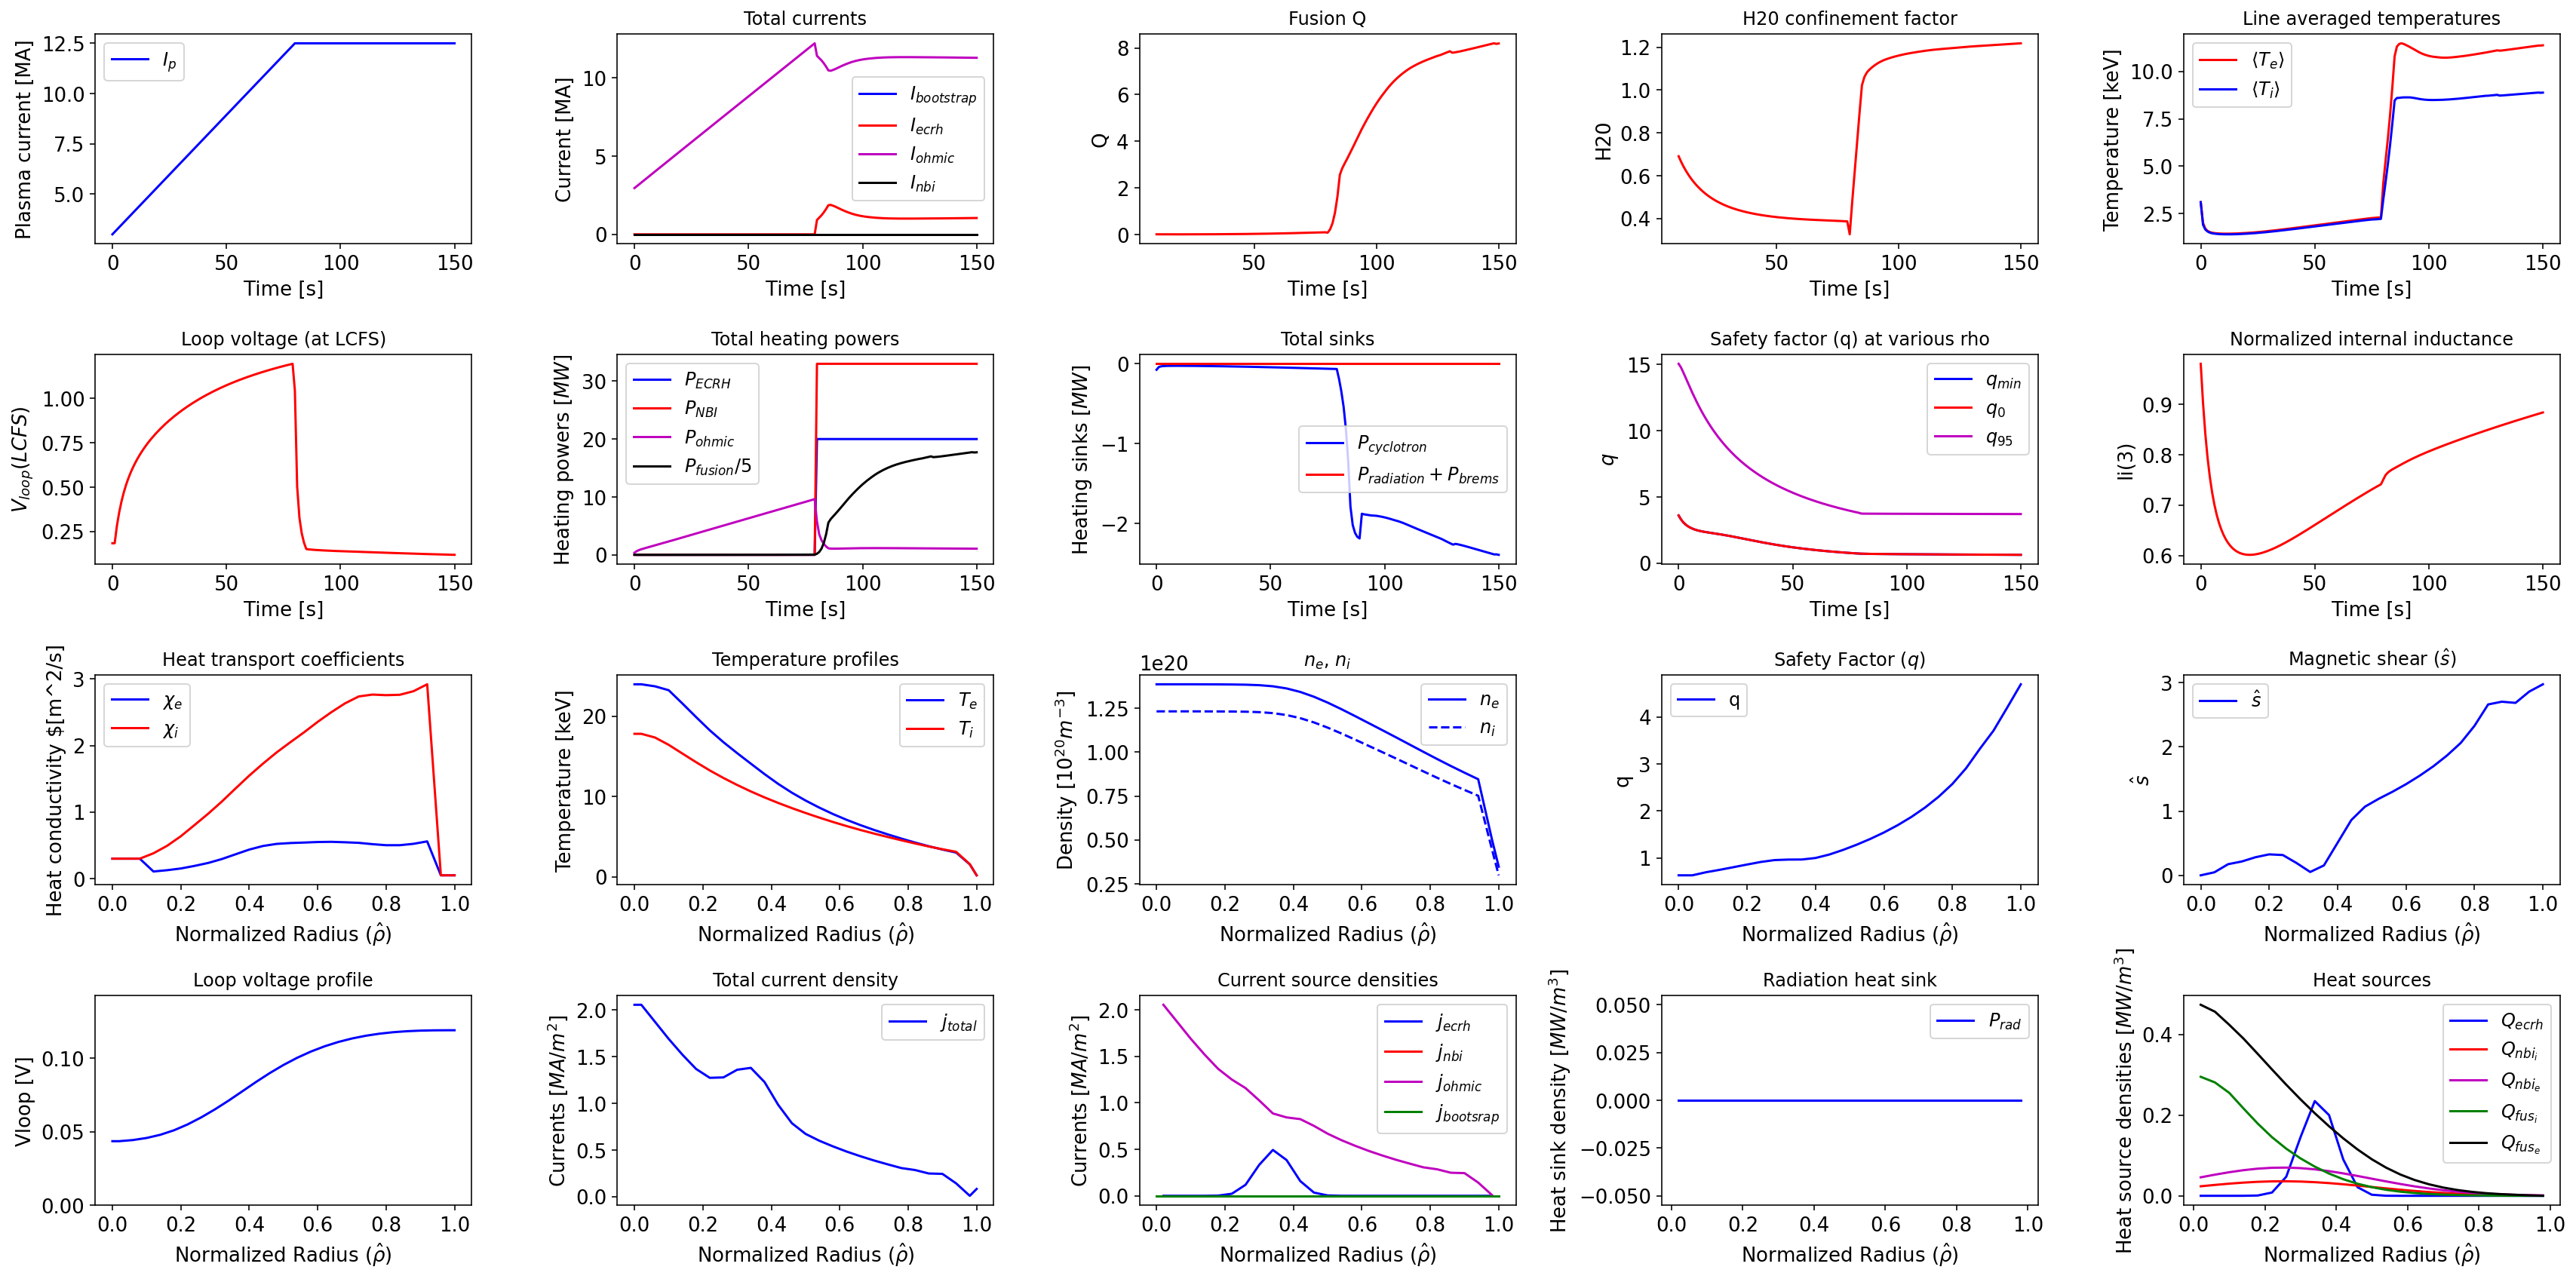

In [177]:
detailed_plot_single_sim(out0, time = 150)